###  备注

#（1）【目的】：《阿里天池大赛_资金流入流出预测数据集》数据预处理，切割出训练集用户和测试集用户
#（2）【Author】：shasha.mao
#（3）【日期】：2021/02/27
#（4）【数据】：
#（5）【路径】：.\data\Purchase Redemption Data
#（6）【备注】：
#（7）【更改】：初版 2020/02/27

### 总结

#判断有无缺失值，所有缺失值一律按0进行填充
#按日期对user_balance_table表进行了聚合
#按日期为主键进行了多表join
#对日期进行编码，0为工作日，1为周末但不是传统节日，2为传统节日
#最终的数据集按日期升序排列
#数据集的时间范围【20130701-2014.08.31】

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import util
import os
import sys
import datetime
import tqdm
import logging
import chinese_calendar

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

%matplotlib inline
sns.set()

In [2]:
print('运行时间 : ', datetime.datetime.now())

运行时间 :  2021-03-01 21:26:12.494684


### 数据集导入

#### 用户数据集和行为数据集 

In [3]:
# 用户信息表
user_profile_table = pd.read_csv(r".\data\Purchase Redemption Data\user_profile_table.csv")
print(user_profile_table.shape, user_profile_table.dropna().shape)
user_profile_table.head()

(28041, 4) (28041, 4)


,user_id,sex,city,constellation
0,2,1,6411949,狮子座
1,12,1,6412149,摩羯座
2,22,1,6411949,双子座
3,23,1,6411949,双鱼座
4,25,1,6481949,双鱼座


In [4]:
# 用户申购赎回数据表,有缺失值
user_balance_table = pd.read_csv(r".\data\Purchase Redemption Data\user_balance_table.csv")
print(user_balance_table.shape, user_balance_table.dropna().shape)
user_balance_table.head()

(2840421, 18) (173739, 18)


,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


#user_balance_table表中的如下字段存在缺失值
#category1               True
#category2               True
#category3               True
#category4               True

In [5]:
user_balance_table.isnull().any()

user_id                False
report_date            False
tBalance               False
yBalance               False
total_purchase_amt     False
direct_purchase_amt    False
purchase_bal_amt       False
purchase_bank_amt      False
total_redeem_amt       False
consume_amt            False
transfer_amt           False
tftobal_amt            False
tftocard_amt           False
share_amt              False
category1               True
category2               True
category3               True
category4               True
dtype: bool

In [6]:
user_balance_table.dtypes

user_id                  int64
report_date              int64
tBalance                 int64
yBalance                 int64
total_purchase_amt       int64
direct_purchase_amt      int64
purchase_bal_amt         int64
purchase_bank_amt        int64
total_redeem_amt         int64
consume_amt              int64
transfer_amt             int64
tftobal_amt              int64
tftocard_amt             int64
share_amt                int64
category1              float64
category2              float64
category3              float64
category4              float64
dtype: object

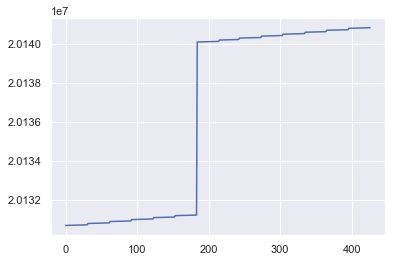

In [7]:
x = list(set(user_balance_table.report_date.sort_values()))
x.sort()

plt.plot(range(len(x)),x)

#### 公共数据集（都只提供到2014.08.29日）

In [8]:
# comp_predict_table = pd.read_csv(r".\data\Purchase Redemption Data\comp_predict_table.csv")  # 答题卡模板

In [9]:
# 上海银行间同业拆放利率表
mfd_bank_shibor = pd.read_csv(r".\data\Purchase Redemption Data\mfd_bank_shibor.csv")
print(mfd_bank_shibor.shape, mfd_bank_shibor.dropna().shape)
print(mfd_bank_shibor.mfd_date)
mfd_bank_shibor.head()

(294, 9) (294, 9)
0      20130701
1      20130702
2      20130703
3      20130704
4      20130705
         ...   
289    20140825
290    20140826
291    20140827
292    20140828
293    20140829
Name: mfd_date, Length: 294, dtype: int64


,mfd_date,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,Interest_6_M,Interest_9_M,Interest_1_Y
0,20130701,4.456,5.423,6.040,6.8800,5.295,4.2390,4.2820,4.4125
1,20130702,3.786,4.750,5.074,5.8000,5.211,4.2344,4.2808,4.4070
2,20130703,3.400,4.242,4.658,5.2000,5.148,4.2300,4.2796,4.4022
3,20130704,3.348,3.938,4.464,5.1020,5.029,4.2287,4.2776,4.4000
4,20130705,3.380,3.816,4.295,4.7885,4.939,4.2273,4.2749,4.4000


In [10]:
# 收益率表
mfd_day_share_interest = pd.read_csv(r".\data\Purchase Redemption Data\mfd_day_share_interest.csv")
print(mfd_day_share_interest.shape, mfd_day_share_interest.dropna().shape)
print(mfd_day_share_interest.mfd_date)
mfd_day_share_interest.head()

(427, 3) (427, 3)
0      20130701
1      20130702
2      20130703
3      20130704
4      20130705
         ...   
422    20140827
423    20140828
424    20140829
425    20140830
426    20140831
Name: mfd_date, Length: 427, dtype: int64


,mfd_date,mfd_daily_yield,mfd_7daily_yield
0,20130701,1.5787,6.307
1,20130702,1.5461,6.174
2,20130703,1.4670,6.034
3,20130704,1.4223,5.903
4,20130705,1.3845,5.739


###  对用户行为表进行宏观统计

#### 用户个数分析 

In [11]:
user_profile_table.shape[0],len(set(user_balance_table.user_id))

(28041, 28041)

#### 数据预处理 

#用0填充缺失值

In [12]:
user_balance_table.head(2)

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [13]:
user_balance_table_df = user_balance_table.fillna(0)
user_balance_table_df.dropna().shape,user_balance_table.shape

((2840421, 18), (2840421, 18))

#按日期分组，对tBalance、yBalance求平均，对其他字段求和

In [14]:
user_balance_table_analysis = user_balance_table_df.groupby("report_date").aggregate({'tBalance': "mean",
                                                                                        'yBalance': "mean",
                                                                                        'total_purchase_amt': "sum",
                                                                                        'direct_purchase_amt': "sum",
                                                                                        'purchase_bal_amt': "sum",
                                                                                        'purchase_bank_amt': "sum",
                                                                                        'total_redeem_amt': "sum",
                                                                                        'consume_amt': "sum",
                                                                                        'transfer_amt': "sum",
                                                                                        'tftobal_amt': "sum",
                                                                                        'tftocard_amt': "sum",
                                                                                        'share_amt': "sum",
                                                                                        'category1': "sum",
                                                                                        'category2': "sum",
                                                                                        'category3': "sum",
                                                                                        'category4': "sum"}).reset_index()

user_balance_table_analysis.head()

,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,20130701,572172.020408,511030.691610,32488348,32458786,21250722,11208064,5525022,382160,5142862,5142862,0,29562,0.0,89350.0,0.0,292810.0
1,20130702,580855.631250,525683.043750,29037390,29007510,16561183,12446327,2554548,350066,2204482,2204482,0,29880,0.0,1650.0,0.0,348416.0
2,20130703,601458.128257,558738.883768,27270770,27234156,20493660,6740496,5953867,454406,5499461,5499461,0,36614,0.0,69764.0,0.0,384642.0
3,20130704,596631.093690,573857.755258,18321185,18282230,12108178,6174052,6410729,535391,5875338,5875338,0,38955,25078.0,107500.0,0.0,402813.0
4,20130705,589932.397059,573599.378676,11648749,11607991,6930431,4677560,2763587,697926,2065661,2065661,0,40758,0.0,51100.0,0.0,646826.0


### 多表join，每日一条记录：包括当前资金宏观统计数据、当前各种利率

In [15]:
for series in [mfd_bank_shibor.mfd_date,mfd_day_share_interest.mfd_date, user_balance_table_analysis.report_date]:
    print(len(set(series)))

294
427
427


In [16]:
# mfd_bank_shibor与mfd_day_share_interest.mfd_date join
temp_df = pd.merge(mfd_bank_shibor, mfd_day_share_interest, how="outer")
final_df = pd.merge(temp_df, user_balance_table_analysis,
                    left_on="mfd_date", right_on="report_date", how="outer").drop("mfd_date", axis="columns")

# 按日期排序
final_df.sort_values(by="report_date", ascending=True, inplace=True)
print(final_df.shape)
final_df.head()

(427, 27)


,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,Interest_6_M,Interest_9_M,Interest_1_Y,mfd_daily_yield,mfd_7daily_yield,...,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,4.456,5.423,6.040,6.8800,5.295,4.2390,4.2820,4.4125,1.5787,6.307,...,5525022,382160,5142862,5142862,0,29562,0.0,89350.0,0.0,292810.0
1,3.786,4.750,5.074,5.8000,5.211,4.2344,4.2808,4.4070,1.5461,6.174,...,2554548,350066,2204482,2204482,0,29880,0.0,1650.0,0.0,348416.0
2,3.400,4.242,4.658,5.2000,5.148,4.2300,4.2796,4.4022,1.4670,6.034,...,5953867,454406,5499461,5499461,0,36614,0.0,69764.0,0.0,384642.0
3,3.348,3.938,4.464,5.1020,5.029,4.2287,4.2776,4.4000,1.4223,5.903,...,6410729,535391,5875338,5875338,0,38955,25078.0,107500.0,0.0,402813.0
4,3.380,3.816,4.295,4.7885,4.939,4.2273,4.2749,4.4000,1.3845,5.739,...,2763587,697926,2065661,2065661,0,40758,0.0,51100.0,0.0,646826.0


#仅mfd_bank_shibor表中的值存在缺失字段，join后的df总共427行，说明正确

In [17]:
final_df.report_date

0      20130701
1      20130702
2      20130703
3      20130704
4      20130705
         ...   
291    20140827
292    20140828
293    20140829
425    20140830
426    20140831
Name: report_date, Length: 427, dtype: int64

In [18]:
len(set(final_df.report_date))

427

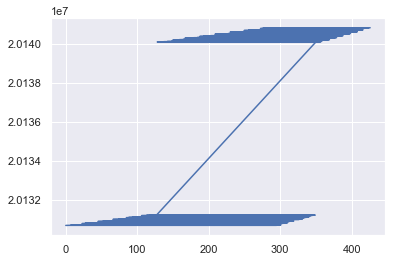

In [19]:
final_df.report_date.plot()

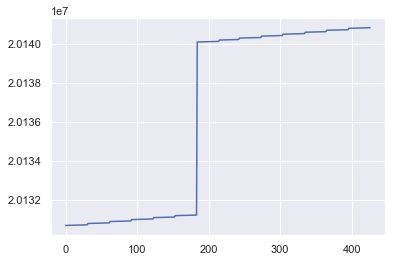

In [20]:
x = final_df.report_date
plt.plot(range(len(final_df.report_date)), x.sort_values())

In [21]:
final_df.isnull().any()

Interest_O_N            True
Interest_1_W            True
Interest_2_W            True
Interest_1_M            True
Interest_3_M            True
Interest_6_M            True
Interest_9_M            True
Interest_1_Y            True
mfd_daily_yield        False
mfd_7daily_yield       False
report_date            False
tBalance               False
yBalance               False
total_purchase_amt     False
direct_purchase_amt    False
purchase_bal_amt       False
purchase_bank_amt      False
total_redeem_amt       False
consume_amt            False
transfer_amt           False
tftobal_amt            False
tftocard_amt           False
share_amt              False
category1              False
category2              False
category3              False
category4              False
dtype: bool

#### 用0填充缺失值 

In [22]:
final_df.fillna(0, inplace=True)

### 对日期进行标识

In [23]:
# 将int64类型转化为datetime类型
date_series = final_df.report_date.apply(lambda x: str(x)).apply(pd.to_datetime)
final_df["year"] = date_series.apply(lambda x: x.year)
final_df["month"] = date_series.apply(lambda x: x.month)
final_df["day"] = date_series.apply(lambda x: x.day)

https://blog.csdn.net/z812215522/article/details/113257803

In [24]:
# 将int64类型转化为datetime类型
date_series = final_df.report_date.apply(lambda x: str(x)).apply(lambda x: datetime.date(int(x[0:4]), int(x[4:6]), int(x[6:])))
final_df["year"] = date_series.apply(lambda x: x.year)
final_df["month"] = date_series.apply(lambda x: x.month)
final_df["day"] = date_series.apply(lambda x: x.day)
# final_df["is_holiday"] = date_series.apply(chinese_calendar.is_holiday)
final_df["get_holiday_detail"] = date_series.apply(chinese_calendar.get_holiday_detail)

def holiday_code(x):
    # 对日期进行编码，0为工作日，1为周末但不是传统节日，2为传统节日
    if x[0]:
        if x[1] is not None:
            return 2
        else:
            return 1
    else:
        return 0

final_df["holiday_detail"] = final_df.get_holiday_detail.apply(holiday_code)

### 去除无关列，并对列名进行排序

In [25]:
final_df.columns

Index(['Interest_O_N', 'Interest_1_W', 'Interest_2_W', 'Interest_1_M',
       'Interest_3_M', 'Interest_6_M', 'Interest_9_M', 'Interest_1_Y',
       'mfd_daily_yield', 'mfd_7daily_yield', 'report_date', 'tBalance',
       'yBalance', 'total_purchase_amt', 'direct_purchase_amt',
       'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt',
       'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt',
       'share_amt', 'category1', 'category2', 'category3', 'category4', 'year',
       'month', 'day', 'get_holiday_detail', 'holiday_detail'],
      dtype='object')

In [26]:
aim_col = ['report_date', 'year','month', 'day', 'holiday_detail', 'Interest_O_N', 'Interest_1_W', 'Interest_2_W', 'Interest_1_M',
           'Interest_3_M', 'Interest_6_M', 'Interest_9_M', 'Interest_1_Y',
           'mfd_daily_yield', 'mfd_7daily_yield', 'tBalance',
           'yBalance', 'total_purchase_amt', 'direct_purchase_amt',
           'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt',
           'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt',
           'share_amt', 'category1', 'category2', 'category3', 'category4']

save_df = pd.DataFrame(final_df, columns=aim_col)
save_df.head()

,report_date,year,month,day,holiday_detail,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,...,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,20130701,2013,7,1,0,4.456,5.423,6.040,6.8800,5.295,...,5525022,382160,5142862,5142862,0,29562,0.0,89350.0,0.0,292810.0
1,20130702,2013,7,2,0,3.786,4.750,5.074,5.8000,5.211,...,2554548,350066,2204482,2204482,0,29880,0.0,1650.0,0.0,348416.0
2,20130703,2013,7,3,0,3.400,4.242,4.658,5.2000,5.148,...,5953867,454406,5499461,5499461,0,36614,0.0,69764.0,0.0,384642.0
3,20130704,2013,7,4,0,3.348,3.938,4.464,5.1020,5.029,...,6410729,535391,5875338,5875338,0,38955,25078.0,107500.0,0.0,402813.0
4,20130705,2013,7,5,0,3.380,3.816,4.295,4.7885,4.939,...,2763587,697926,2065661,2065661,0,40758,0.0,51100.0,0.0,646826.0


In [27]:
save_df.query("year==2013").head(2)

,report_date,year,month,day,holiday_detail,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,...,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,20130701,2013,7,1,0,4.456,5.423,6.040,6.88,5.295,...,5525022,382160,5142862,5142862,0,29562,0.0,89350.0,0.0,292810.0
1,20130702,2013,7,2,0,3.786,4.750,5.074,5.80,5.211,...,2554548,350066,2204482,2204482,0,29880,0.0,1650.0,0.0,348416.0


In [28]:
save_df.query("year==2013")

,report_date,year,month,day,holiday_detail,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,...,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,20130701,2013,7,1,0,4.456,5.423,6.040,6.8800,5.2950,...,5525022,382160,5142862,5142862,0,29562,0.0,89350.0,0.0,292810.0
1,20130702,2013,7,2,0,3.786,4.750,5.074,5.8000,5.2110,...,2554548,350066,2204482,2204482,0,29880,0.0,1650.0,0.0,348416.0
2,20130703,2013,7,3,0,3.400,4.242,4.658,5.2000,5.1480,...,5953867,454406,5499461,5499461,0,36614,0.0,69764.0,0.0,384642.0
3,20130704,2013,7,4,0,3.348,3.938,4.464,5.1020,5.0290,...,6410729,535391,5875338,5875338,0,38955,25078.0,107500.0,0.0,402813.0
4,20130705,2013,7,5,0,3.380,3.816,4.295,4.7885,4.9390,...,2763587,697926,2065661,2065661,0,40758,0.0,51100.0,0.0,646826.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,20131227,2013,12,27,0,3.513,5.067,5.949,6.4920,5.5465,...,163522548,22373377,141149171,16737992,124411179,1300045,11444298.0,3800278.0,200.0,7128601.0
348,20131228,2013,12,28,1,0.000,0.000,0.000,0.0000,0.0000,...,61383220,18517636,42865584,10339282,32526302,1301462,11610509.0,1046328.0,0.0,5860799.0
349,20131229,2013,12,29,1,0.000,0.000,0.000,0.0000,0.0000,...,55129989,15925186,39204803,5655465,33549338,1293954,7212414.0,1422026.0,10100.0,7280646.0
126,20131230,2013,12,30,0,3.205,4.841,5.907,6.1220,5.5530,...,179826624,20652334,159174290,40393506,118780784,1295824,8770053.0,3669174.0,0.0,8213107.0


In [29]:
save_df.query("year==2014")

,report_date,year,month,day,holiday_detail,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,...,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
350,20140101,2014,1,1,2,0.000,0.000,0.0000,0.000,0.0000,...,77367755,21750788,55616967,15782631,39834336,1370848,9463186.0,7180059.0,0.0,5107543.0
128,20140102,2014,1,2,0,3.131,4.981,5.7590,5.910,5.5657,...,190155450,22941048,167214402,26734732,140479670,1425250,6429483.0,6583823.0,0.0,9927742.0
129,20140103,2014,1,3,0,3.006,4.711,5.5240,6.201,5.5661,...,127714255,23841309,103872946,27165547,76707399,1434209,10507984.0,4191467.0,50000.0,9091858.0
351,20140104,2014,1,4,1,0.000,0.000,0.0000,0.000,0.0000,...,99869074,21965772,77903302,10496655,67406647,1478659,13162251.0,1833288.0,0.0,6970233.0
352,20140105,2014,1,5,1,0.000,0.000,0.0000,0.000,0.0000,...,156781996,20843557,135938439,37596243,98342196,1470907,12945726.0,2302192.0,0.0,5595639.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,20140827,2014,8,27,0,2.861,3.349,3.9828,4.178,4.6680,...,468164147,107408171,360755976,20966937,339789039,2221794,34053795.0,19426628.0,6000000.0,47927748.0
292,20140828,2014,8,28,0,2.876,3.538,4.0500,4.133,4.6689,...,297893861,98896299,198997562,15732174,183265388,2195104,25606866.0,25743565.0,4000000.0,43545868.0
293,20140829,2014,8,29,0,2.908,3.672,4.1990,4.114,4.6659,...,273756380,103967802,169788578,27979322,141809256,2219541,31191914.0,30028785.0,40000.0,42707103.0
425,20140830,2014,8,30,1,0.000,0.000,0.0000,0.000,0.0000,...,196374134,70813897,125560237,32453185,93107052,2225109,18388231.0,14302883.0,100000.0,38022783.0


In [31]:
save_df.to_excel(r".\data\dateset.xlsx", index=0)